In [1]:
import sys
print(sys.executable)

C:\Users\sunde\Downloads\Anaconda\envs\speech_recog\python.exe


In [2]:
import os 
import pandas as pd
import numpy as np
import csv
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
import librosa
import IPython.display as ipd
import librosa.display
from scipy.io import wavfile
from scipy.fftpack import fft
from scipy import signal
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard
from sklearn.utils import shuffle
from tensorflow.keras.layers import Input, LSTM, Dense , AveragePooling2D ,TimeDistributed
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pickle
from sklearn.metrics import classification_report

In [3]:
!pip install C:\Users\sunde\Downloads\tensorflow-speech-recognition-challenge\tensorflow_cpu-2.20.0-cp311-cp311-win_amd64.whl

Processing c:\users\sunde\downloads\tensorflow-speech-recognition-challenge\tensorflow_cpu-2.20.0-cp311-cp311-win_amd64.whl
tensorflow-cpu is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [4]:
print(f"Current working directory: {os.getcwd()}")

Current working directory: C:\Users\sunde\Downloads\tensorflow-speech-recognition-challenge


In [5]:
os.chdir(r"train/audio")
print(f"Current working directory: {os.getcwd()}")

Current working directory: C:\Users\sunde\Downloads\tensorflow-speech-recognition-challenge\train\audio


In [6]:
data = pd.read_csv('C:/Users/sunde/Downloads/tensorflow-speech-recognition-challenge/train/audio/data1.csv')
data = data[data['label'] != '_background_noise_']
print(data.shape)

(64721, 2)


In [7]:
data.head(5)

,file_name,label
0,bed/00176480_nohash_0.wav,bed
1,bed/004ae714_nohash_0.wav,bed
2,bed/004ae714_nohash_1.wav,bed
3,bed/00f0204f_nohash_0.wav,bed
4,bed/00f0204f_nohash_1.wav,bed


In [8]:
# get all raw data
raw_data = []
for i in tqdm(data['file_name']):
    signal , rate = librosa.load(i , sr=16000)
    #signal = list(signal)
    raw_data.append(signal)

  0%|          | 0/64721 [00:00<?, ?it/s]

In [9]:
idx = 100
samples = raw_data[idx]
sample_rate = 16000
print('Label : ',data['label'][idx:idx+1].values[0])
ipd.Audio(samples, rate = sample_rate)

Label :  bed


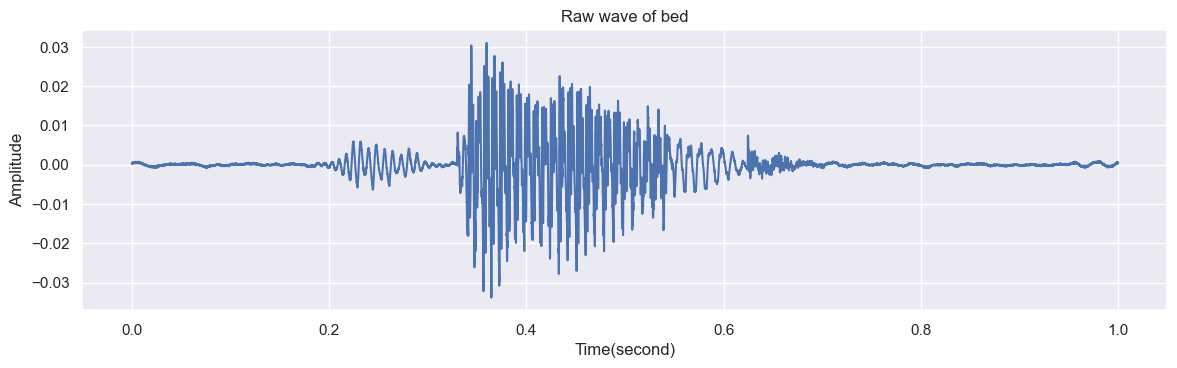

In [10]:
 sns.set_theme()
 fig = plt.figure(figsize=(14, 8))
 ax = fig.add_subplot(211)
 ax.set_title('Raw wave of '+ 'bed')
 ax.set_xlabel('Time(second)')
 ax.set_ylabel('Amplitude')
 ax.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)
 plt.show()

In [11]:
 def plot_signals(signals):
     fig , ax = plt.subplots(nrows = 6 , ncols = 5 , figsize = (20,15))
     i = 0
     for x in range(6):
         for y in range(5):
             ax[x,y].set_title(list(signals.keys())[i])
             ax[x,y].plot(list(signals.values())[i])
             ax[x,y].get_xaxis().set_visible(False)
             ax[x,y].get_yaxis().set_visible(False)
             i += 1

In [12]:
# store all signal in dic
signals = {}
labels = np.unique(data['label'])
# get all signal array except backgroud noise
for name in labels:
    file = data[data['label'] == name ][:1]
    signal , rate = librosa.load(file['file_name'].values[0])
    signals[name] = signal

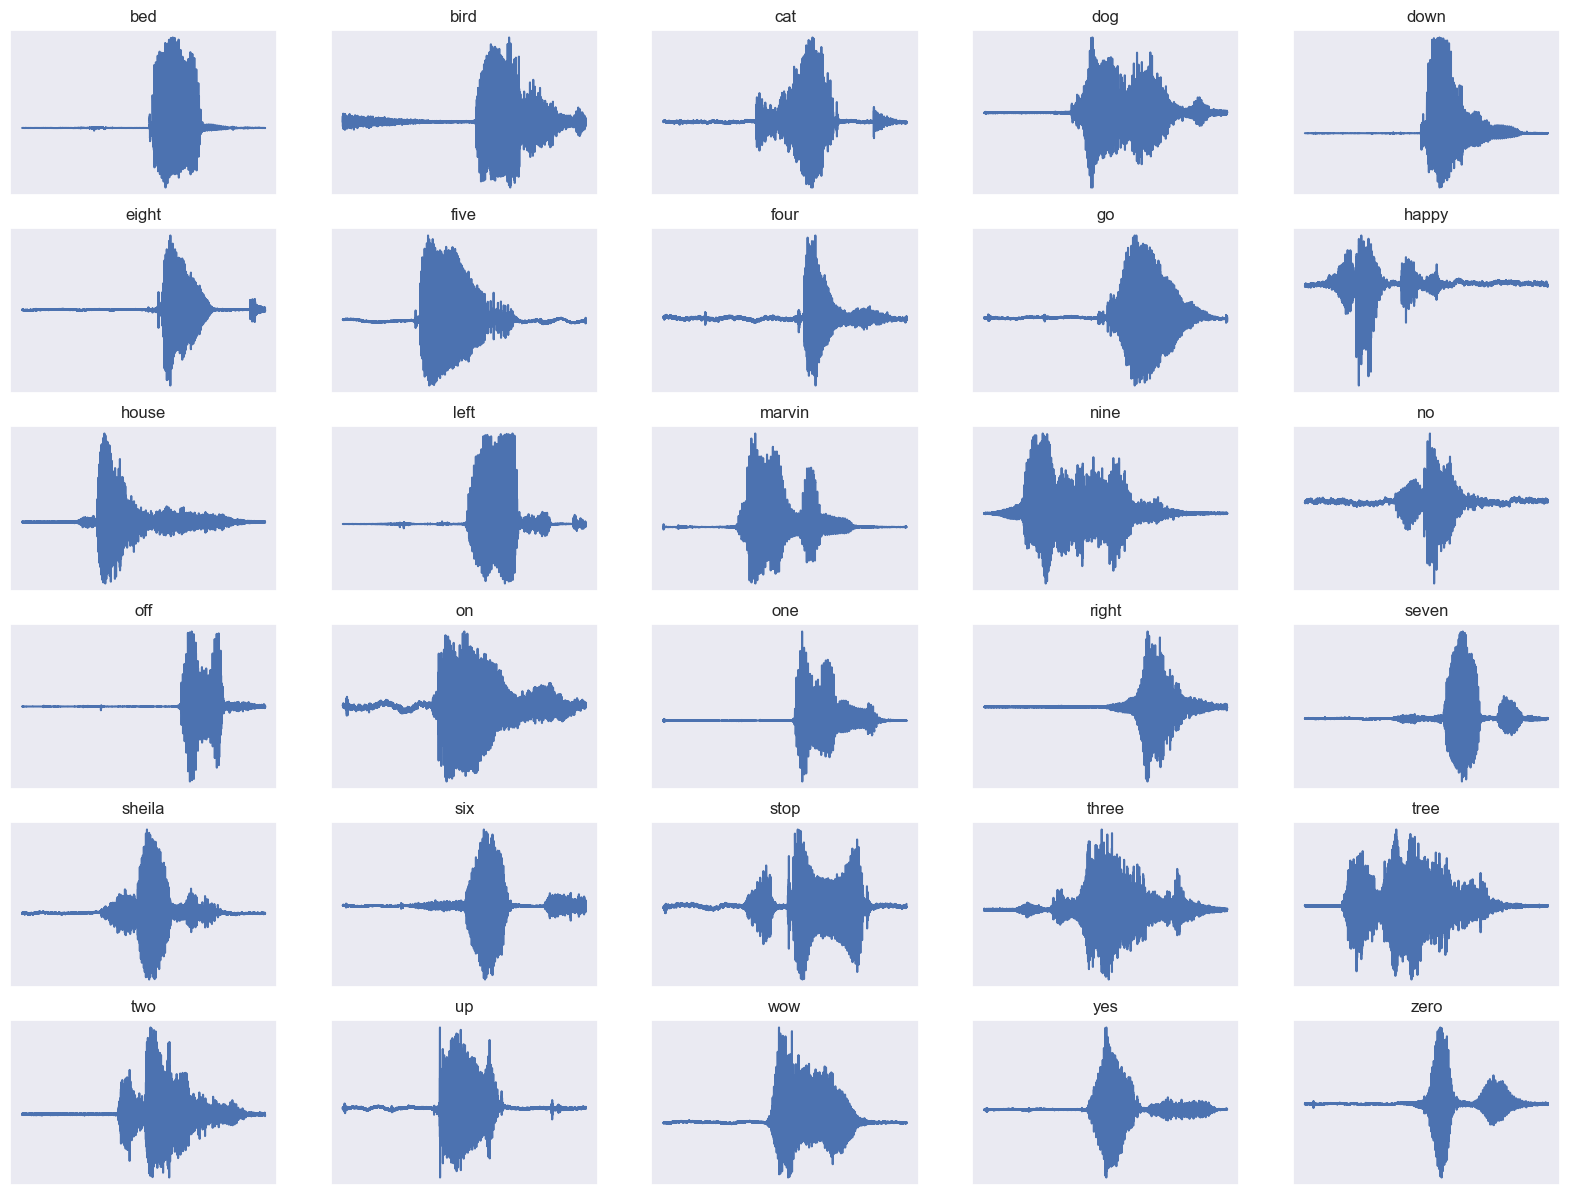

In [13]:
 plot_signals(signals)
 plt.show()

In [14]:
# ''' padding - make all file same length(16000) '''
# # if len of audio is < 16000 we add zeros.
# # if len of audio is > 16000 we truncate.
# def padding(data, size):
#     if len(data) >= size:
#         arr = data[:size]
#     else:
#         arr = np.zeros(size)
#         arr[:len(data)] = data
#         return arr

In [15]:
data['raw_data'] = raw_data

In [16]:
def pad_or_truncate(data, target_len=16000, column="raw_data"):
   
    padded = []
    for signal in tqdm(data[column], desc="Padding/Truncating"):
        sig = np.array(signal)

        if len(sig) < target_len:
            # Pad zeros at end
            sig = np.pad(sig, (0, target_len - len(sig)), mode='constant')
        else:
            # Truncate
            sig = sig[:target_len]

        padded.append(sig)
        
    # add padded sequences as a new column
    data["pad_seq"] = padded

    # optionally save
    # if save_csv:
    #     data.to_csv(csv_name, index=False)
    #     print(f"Saved CSV: {csv_name}")

    return data

In [17]:
data= pad_or_truncate(data, target_len=16000, column="raw_data")



Padding/Truncating:   0%|          | 0/64721 [00:00<?, ?it/s]

In [18]:
data.head(5)

,file_name,label,raw_data,pad_seq
0,bed/00176480_nohash_0.wav,bed,"[9.1552734e-05, 3.0517578e-05, 0.00018310547, ...","[9.1552734e-05, 3.0517578e-05, 0.00018310547, ..."
1,bed/004ae714_nohash_0.wav,bed,"[-0.003326416, -0.004547119, -0.0043945312, -0...","[-0.003326416, -0.004547119, -0.0043945312, -0..."
2,bed/004ae714_nohash_1.wav,bed,"[-0.0025024414, -0.002105713, -0.001739502, -0...","[-0.0025024414, -0.002105713, -0.001739502, -0..."
3,bed/00f0204f_nohash_0.wav,bed,"[-0.00024414062, -0.00033569336, -0.0003356933...","[-0.00024414062, -0.00033569336, -0.0003356933..."
4,bed/00f0204f_nohash_1.wav,bed,"[-0.00036621094, -0.00045776367, -0.0004577636...","[-0.00036621094, -0.00045776367, -0.0004577636..."


In [19]:
y=data['label']

In [29]:
 data = shuffle(data,random_state=33)
 #y = data['label']
 #data = data.drop('label',axis = 1)
 x_train , x_vali, y_train, y_vali = train_test_split(data['pad_seq'].values, y,test_size=0.2,random_state=42,stratify=y)   

In [30]:
y.head(5)

0    bed
1    bed
2    bed
3    bed
4    bed
Name: label, dtype: object

In [32]:
 #for error enalysis
 np.save('train_pad.npy', x_train)
 y_train.to_csv('y_train.csv', index = False)
 np.save('vali_pad.npy', x_vali)
 y_vali.to_csv('y_vali.csv', index = False)

In [33]:
 print(x_train.shape, y_train.shape)
 print(x_vali.shape, y_vali.shape )

(51776,) (51776,)
(12945,) (12945,)


In [34]:
a=np.load('train_pad.npy', allow_pickle=True)
print(a.shape)

(51776,)


In [35]:
print(a[:8])

[array([ 0.00344849,  0.00421143,  0.00491333, ..., -0.00396729,
        -0.00378418, -0.00360107], shape=(16000,), dtype=float32)
 array([0.0000000e+00, 6.1035156e-05, 6.1035156e-05, ..., 9.1552734e-05,
        6.1035156e-05, 9.1552734e-05], shape=(16000,), dtype=float32)
 array([-0.04431152, -0.05908203, -0.07815552, ..., -0.04641724,
        -0.04788208, -0.04516602], shape=(16000,), dtype=float32)
 array([-6.1035156e-05,  3.0517578e-05,  1.2207031e-04, ...,
        -2.8259277e-02,  2.6611328e-02,  4.1198730e-03],
       shape=(16000,), dtype=float32)
 array([-3.0517578e-05,  6.1035156e-05,  1.2207031e-04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       shape=(16000,), dtype=float32)
 array([0.0010376 , 0.00112915, 0.0012207 , ..., 0.00234985, 0.0027771 ,
        0.00271606], shape=(16000,), dtype=float32)
 array([ 1.2207031e-04,  9.1552734e-05,  6.1035156e-05, ...,
         7.3242188e-04, -5.2185059e-03, -6.9580078e-03],
       shape=(16000,), dtype=float32)
 a

In [36]:
def log_spectrogram(audio, sample_rate, window_size=20,step_size=10, eps=1e-10):
  nperseg = int(round(window_size * sample_rate / 1e3))
  noverlap = int(round(step_size * sample_rate / 1e3))
  freqs, times, spec = signal.spectrogram(audio,
  fs=sample_rate,
  window='hann',
  nperseg = nperseg,
  noverlap = noverlap,
  detrend=False)
  return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [37]:
from scipy import signal
train_data = []
for i in tqdm(x_train):
    _,_,spec = log_spectrogram(i,16000)
    train_data.append(spec)
train_data = np.array(train_data)
train_data.shape

  0%|          | 0/51776 [00:00<?, ?it/s]

(51776, 99, 161)

In [38]:
len(data['pad_seq'][0])

16000

In [40]:
 np.save('log_train_data.npy', train_data)
 del train_data

In [41]:
 vali_data = []
 for i in tqdm(x_vali):
     _,_,spec = log_spectrogram(i,16000)
     vali_data.append(spec)
 vali_data = np.array(vali_data)
 vali_data.shape

  0%|          | 0/12945 [00:00<?, ?it/s]

(12945, 99, 161)

In [42]:
np.save('log_vali_data.npy', vali_data)

In [43]:
 train_data = np.load('log_train_data.npy', allow_pickle=True)
 vali_data  = np.load('log_vali_data.npy', allow_pickle=True)
 y_train = pd.read_csv('y_train.csv')
 y_vali = pd.read_csv('y_vali.csv')

In [44]:
 # reshape because we use conv2d Here
 train_data = train_data.reshape(tuple(list(train_data.shape) + [1] ))
 train_data.shape

(51776, 99, 161, 1)

In [45]:
 vali_data = vali_data.reshape(tuple(list(vali_data.shape) + [1] ))
 vali_data.shape

(12945, 99, 161, 1)

In [47]:
print(y_train.shape)

(51776, 1)


In [51]:
total = pd.concat([y_train, y_vali], axis=0, ignore_index=True)
print(len(total.label.unique()))
total.label.unique()

30


array(['three', 'zero', 'marvin', 'wow', 'nine', 'happy', 'six', 'house',
       'four', 'on', 'up', 'stop', 'tree', 'cat', 'off', 'no', 'seven',
       'go', 'eight', 'yes', 'bed', 'left', 'right', 'five', 'one',
       'sheila', 'dog', 'down', 'two', 'bird'], dtype=object)

In [52]:
 encoder = LabelEncoder()
 encoder.fit(total)
 y_train = encoder.transform(y_train)
 y_vali = encoder.transform(y_vali)
 #y_test = encoder.transform(y_test)

In [53]:
 y_train.shape , y_vali.shape

((51776,), (12945,))

In [75]:
 model_7 = tf.keras.Sequential()
 model_7.add(Input(shape=(99,161,1)))
 model_7.add(BatchNormalization())
 model_7.add(Conv2D(8,kernel_size=2,activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
 model_7.add(Conv2D(8,kernel_size=3,activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
 model_7.add(MaxPooling2D(pool_size=(2,2)))
 model_7.add(Dropout(rate=0.2))
 model_7.add(Conv2D(16,kernel_size=5,activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
 model_7.add(Conv2D(16,kernel_size=6,activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
 model_7.add(MaxPooling2D(pool_size=(2,2)))
 model_7.add(Dropout(rate=0.2))
 model_7.add(Conv2D(16,kernel_size=6,activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
 model_7.add(MaxPooling2D(pool_size=(2,2)))
 model_7.add(Flatten())
 model_7.add(Dense(256, activation='relu'))
 model_7.add(BatchNormalization())
 model_7.add(Dense(128, activation='relu'))
 model_7.add(BatchNormalization())
 model_7.add(Dense(30, activation='softmax'))

In [76]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# model_7 = Sequential()
# model_7.add(Input(shape=(99, 161, 1)))
# model_7.add(BatchNormalization())

# model_7.add(Conv2D(
#     8,
#     kernel_size=2,
#     activation='relu',
#     kernel_regularizer=tf.keras.regularizers.l2(0.001)
# ))
# model_7.add(Conv2D(
#     8,
#     kernel_size=3,
#     activation='relu',
#     kernel_regularizer=tf.keras.regularizers.l2(0.001)
# ))
# model_7.add(MaxPooling2D(pool_size=(2, 2)))
# model_7.add(Dropout(rate=0.2))

# model_7.add(Conv2D(
#     16,
#     kernel_size=5,
#     activation='relu',
#     kernel_regularizer=tf.keras.regularizers.l2(0.001)
# ))
# model_7.add(Conv2D(
#     16,
#     kernel_size=6,
#     activation='relu',
#     kernel_regularizer=tf.keras.regularizers.l2(0.001)
# ))
# model_7.add(MaxPooling2D(pool_size=(2, 2)))
# model_7.add(Dropout(rate=0.2))

# model_7.add(Conv2D(
#     16,
#     kernel_size=6,
#     activation='relu',
#     kernel_regularizer=tf.keras.regularizers.l2(0.001)
# ))
# model_7.add(MaxPooling2D(pool_size=(2, 2)))

# model_7.add(Flatten())
# model_7.add(Dense(256, activation='relu'))
# model_7.add(BatchNormalization())
# model_7.add(Dense(128, activation='relu'))
# model_7.add(BatchNormalization())
# model_7.add(Dense(30, activation='softmax'))

# model_7.summary()


In [77]:
tensorboard_callback = TensorBoard(log_dir='model-8-3',histogram_freq=1,write_images=True)
def scheduler(epoch, lr):
   if epoch < 5:
       return lr
   else:
       return lr * 0.9
lrs = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)
callbacks = [tensorboard_callback,lrs]

In [78]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model_7.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [79]:
y_train.shape

(51776,)

In [80]:
train_data.shape

(51776, 99, 161, 1)

In [ ]:
history = model_7.fit( train_data ,y_train,
                    epochs = 20,
                    validation_data = ( vali_data ,y_vali) ,
                    callbacks = callbacks)

In [ ]:
 model_7.save('final_model.h5')
 np.save('final_model_classes.npy',encoder.classes_)

In [ ]:

print("y_train shape:", y_train.shape)     # should be (51776,)
print("y_val shape:",   y_vali.shape)       # should be (12945,)

print("y_train min / max:", y_train.min(), y_train.max())
print("unique labels (train):", np.unique(y_train)[:40])

print("number of classes train:", len(np.unique(y_train)))
print("number of classes val:",   len(np.unique(y_vali)))